# Mining Healthy Tweets
### Twitter data analysis with Pyspark

*by Federico Cardoni & Emanuele Cappella*

## Introduction

Sharing health information has never been easier than today, when platforms such as Twitter offer a direct bridge to the general public, often bypassing more traditional health providers [1, 3]. Twitter data has been analyzed for influenza monitoring [2], to determine its impact on lifestyle habits [3], and for understanding how to better disse-minate research findings about health issues [4].
However, large unstructered data sources such as Twitter are difficult to process and analyze. One of the main challenges in this field is topic modeling, that is understanding the hidden structure of texts to reduce the reducing the heterogeneity of data [2]. Hete-rogeneity of sources - and the associated different degrees of reliability - is another hot topic in Twitter analysis right now [6].
In such a context, we chose a twitter dataset on [UCI repository](https://archive.ics.uci.edu/ml/datasets/Health+News+in+Twitter) [2], which contains ~50000 health mes-sages twitted from from 2013 to 2015 by 16 major news agencies (e.g. BBC). Data is or-ganized per news agency, with 16 distinct txt files (~500 to 1200 KB) . For each tweet three pieces of information are available: id, date and time, and text.

## Aims

The first aim of the current research is to analyze tweets to discover their underlying topics. This first step will allow us to understand better what kind of information twitter news agencies find worth disseminating.
Secondly, we wanted to understand how much the news agencies differed in their choice of topics and wording. This research question was prompted by a preliminary reading of the tweets, where we found an high similarity in both themes and wording between diffe-rent agencies, which are likely constrained by the character limit. We wondered what per-centage of accuracy a machine learning prediction algorithm could get in differentiating these texts. Thus, multinomial logistic regression was chosen to predict which news agen-cy tweeted the message from its text.

In conclusion, our two research questions may be summarised as follows:

**1) What are the most relevant health topics trending on Twitter?**

**2) Can we predict which news agency twitted a certain health message?**

## Methods
To address these research questions we used PySpark and pyspark.ml, its machine learning package based on dataframes.
In particular, we implemented two machine learning techniques:

1) **Latent Dirichlet allocation (LDA)**, the most popular method for topic modeling [2], was employed to infer the topics from the unlabeled tweets. LDA is a generative model whe-re latent topics are probability distributions over words, each tweet is a defined by a random mixture of topics, from which each word is drawn [5].

2) **Multinomial logistic regression** is a type of regression technique used for multi-classification problems. In the current analysis, the 16 news agencies represented the possible outcomes, while the text of tweets is the predicting variable.

## Analysis & Results

### 1. Text pre-processing
The 16 text files were uploaded on the server of City's university. We created a function (*LockAndLoad*) to define the RDD we will work on, whose structure consists in three pieces of information: news agency, tweet and date. 
Please note that one new agency (goodhealth) was excluded because its texts contained an unreadable character (this is the reason why the second for loop is applied to 15 elements).

In [1]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [1]:
import re

#Create a function to load the tweets
def LockAndLoad(array):
    rddarray=[]
    filenames=[]

    for i in array:
        text = sc.textFile('hdfs://saltdean/data/Health-Tweets_1/'+ 
                           str(i)).map(lambda a: (a.split('|')))
        name = sc.wholeTextFiles('hdfs://saltdean/data/Health-Tweets_1/'+ str(i))
        name = name.map(lambda x: x[0])
        filenames.append(name)
        text.take(10)
        rddarray.append(text)

    full_rdd = sc.parallelize(str(""))

    for i in range (0,15):
        p = str(filenames[i].take(1))
        nm = re.search('Health-Tweets_1(.*?).txt', p).group(1)
        rdd = rddarray[i].map(lambda x: (str(nm),x[2],x[1]))
        full_rdd = full_rdd.union(rdd)

    return full_rdd

#Apply LockAndLoad
filename_array = ['bbchealth.txt', 'cbchealth.txt', 'cnnhealth.txt', 
                  'everydayhealth.txt', 'foxnewshealth.txt', 
                  'gdnhealthcare.txt', 'KaiserHealthNews.txt', 'latimeshealth.txt', 
                  'msnhealthnews.txt', 'NBChealth.txt', 'nprhealth.txt', 
                  'nytimeshealth.txt', 'reuters_health.txt', 
                  'usnewshealth.txt', 'wsjhealth.txt']

full_rdd = LockAndLoad(filename_array)
full_rdd.take(3)

[('/bbchealth',
  'Breast cancer risk test devised http://bbc.in/1CimpJF',
  'Thu Apr 09 01:31:50 +0000 2015'),
 ('/bbchealth',
  'GP workload harming care - BMA poll http://bbc.in/1ChTBRv',
  'Wed Apr 08 23:30:18 +0000 2015'),
 ('/bbchealth',
  "Short people's 'heart risk greater' http://bbc.in/1ChTANp",
  'Wed Apr 08 23:30:18 +0000 2015')]

Tweet messages were further processed and cleaned with the help of **nltk package**: words were tokenized, converted to lowecase  and stemmed (*stemAndTokenize* function); URL addresses and stopwords removed (*refiner* function); whitespaces were deleted and the date part of the RDD simplified.

In [2]:
import nltk

import re
# define a function for tokenizing and stemming words
def stemAndtokenize(text_final): 
    nltk.download('punkt')
    p = nltk.PorterStemmer()
    tokens = p.stem(text_final)
    tokens = nltk.word_tokenize(text_final)
    tokens = [(word.lower()) for word in tokens]
    tokens = [re.sub('[^A-Za-z0-9]+', '',x) for x in tokens]
    return tokens

def refiner(text):
    tokens = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',text)
    nltk.download("stopwords")
    from nltk.corpus import stopwords
    nltk.data.path.append("/nltk_data")
    stop = stopwords.words('english')
    avoid = ['What', 'I', 'what', 'A', 'US', 'How', 'may', 'says', 'Most', 'most', 
             'Health', 'health', 'healthcare', 'The', 'HealthTalk', 'healthtalk', 
             'To', 'In', 'to', 'in', 'us', 'New', 'Well', 'May', 'Why', 'For', 
             'Is', 'new', 'E', 'EverydayHealth', 'RT', 'NHS', 'with', 'of', 'can', 
             'get', 'on', 'and', 'from', 'http', 'one', 'some', 'do', 'we', 'not', 
             '5', '10', '1', 'could', 'when', '2', 'about', 'but', 'as', 'if', 'no', 
             'up', 'that', 'many', 'our', 'here', 'my', 'who', 'go', 'u', 'via', 'rt']
    
    stop.extend(avoid)
    pattern = re.compile(r'\b(' + r'|'.join(stop) + r')\b\s*')
    text_final = pattern.sub('', tokens)
    
    print(text_final)
    
    return text_final

# Create key-values pair with text on x[1] and dates on x[2]
rdd1 = full_rdd.map(lambda x: (x[2], (x[1])))
# take values
rdd2 = rdd1.values()
# call text refiner, remove URLs and stopwords 
rdd3 = rdd2.map(refiner)
# call tokenizer, tokenize and keep only words, removing hashtags, 
#punctuation and removing plurals....
rdd4 = rdd3.map(stemAndtokenize)
# Zipp keys and values together... 
rdd6 = rdd1.keys().zip(rdd4)
# Setting date to a readable format and delete whitespaces
rdd7 = rdd6.map(lambda x: (x[0][4:7]+(x[0][-4:]), [s for s in x[1] if len(s)>0]))
# Erase eventual white spaces...
rdd_final = rdd7.map(lambda x: (x[0][0:], [word for word in x[1] if len(word)>0]))

print(rdd_final.take(3))

[('Apr2015', ['breast', 'cancer', 'risk', 'test', 'devised']), ('Apr2015', ['gp', 'workload', 'harming', 'care', 'bma', 'poll']), ('Apr2015', ['short', 'people', 'heart', 'risk', 'greater'])]


**Prepare data for analysis**

Here we define two functions that will be used later on to prepare the RDD and transform it to a dataframe, so that to use pyspark.ml library.

In [3]:
# Initialize dataset:
# You can pass inside the initializer an RDD and it will process it by tokenizing, 
#stopword removing, stemming and returning a processed RDD
def initialize(rdd):
# Define the RDD to process, define a tuple of keys and values, where keys are x[1] 
#and they will be our label, and word are the second part of our tuple.  
    rdd = rdd.map(lambda x: (x[0], (x[1])))
    # separate the values from the keys, to work on just on the text 
    values = rdd.values()
    # call the refiner function on the rdd
    rdd_refined = values.map(refiner)
    # call the stemmer and tokenizer function on rdd
    rdd_tokenized = rdd_refined.map(stemAndtokenize)
    # re-zip keys and values together.
    zipped_rdd = rdd.keys().zip(rdd_tokenized)
    # remove empty spaces from RDD due to the refiner and tokenizer actions.
    model_rdd = zipped_rdd.map(lambda x: (x[0][1:], [word for word in x[1] if len(word)>0]))
    
    return model_rdd
    

# This function is meant to convert the RDD in a dataframe processable by 
#pyspark.ml library --- we want to predict the author of the tweet, 
#pyspark.ml need a dataframe object so we need to convert before proceed 
#to the machine learning part.
def to_indexed_dataframe(rdd):
    # define column name for the dataframe
    columns = ['accounts', 'text']
    # transform the rdd into a df with the 
    df = rdd.toDF(columns)
    # transform the tweet author name into a numerical index processable 
    #for multiclass classification.
    indexer = StringIndexer(inputCol="accounts", outputCol="label")
    indexed_df = indexer.fit(df).transform(df)
    
    return indexed_df

### 2. Descriptive analysis
First, we drew a wordcloud in the form of a twitter bird to present the word frequencies. Then, two preliminary analyses were conducted in order to understand better the temporal distribution of data. First, we visualized the number of tweets per months: tweets peaked during winter months, probably because the usual influenza epidemics [1]. We also compared the various news agencies in terms of messages tweeted, with the New York Times leading the group at ~6000 tweets. Second, the countbyMonths function was defined to extract from the RDD the most trending word per months. The top trending words were all related to the Ebola disease, which was the biggest concern during the late 2014.

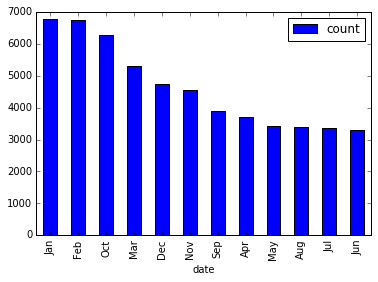

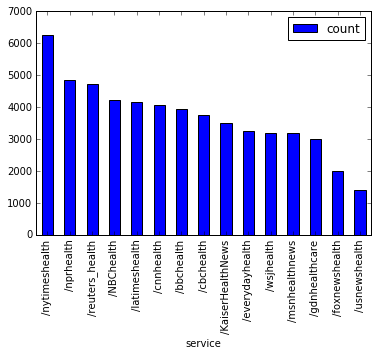

In [4]:
from pyspark.sql import functions as F
from pyspark.sql.functions import concat, col, lit, desc
import matplotlib.pyplot as plt
#Count data by time:

def countby(rdd, var):
    # delete any previous pending plots, if any...
    plt.clf()
    # transform rdd to dataframe object
    stg_ssn = full_rdd.map(lambda p: Row(service=p[0], text=p[1], date=p[2]))
    stg = sqlContext.createDataFrame(full_rdd, ['service','text','date'])
    # Setting time to legible format:
    stg = stg.withColumn('date', concat(stg.date.substr(5,3)))
    # Count by var, it can be service or date (months and years)
    counts = stg.groupBy([var]).count().alias('counts').sort(desc("count"))
    # reduced df is transformed into pandas format
    df = counts.toPandas()
    # plotting...
    df.plot(kind='bar',x=var,y='count',colormap='winter')
    plt.show()

countby(full_rdd, 'date')
countby(full_rdd, 'service')

### WARNING!
#### The code in the following cell takes more than 30 minutes to converge (it may be the for loop). On IBM platform it is definitely faster - we thus suggest to test the other python notebook we produced for the coursework. 
This analysis produced a table showing the most important words per month. The result showed the period in which concerns for Ebola in the USA peaked - from late 2014 to early 2015.

In [8]:
from operator import add

# we want to visualize word by counting them by months,years to see 
#which word has been used the most for a certain month,year.

def countbyMonths(rdd):
    # Collect into array all the months/years
    months = rdd.map(lambda x: x[0]).distinct().collect()
    # Inizialize an Empty RDD
    outputs = sc.parallelize(str(""))
        # Iterate through all the months, this could take some times... go have a tea...
    for i in months:
        # Take all the observations with that particular months and yeara
        #(example: all the text with "oct2014")
        t1 = rdd.filter(lambda x: x[0]==str(i))
        # flatMap to produce touple with key and value (word,1) of the sorted RDD
        t2 = t1.flatMap(lambda x: (x[1])).map(lambda x: (x,1))
        # count by key, to obtain the number of words for that particular combination
        t3 = t2.reduceByKey(add)
        # Order by count
        t4 = t3.sortBy(lambda x: -x[1])
        # attach months/years key to word,count touple.
        t5 = t4.map(lambda x: (str(i) ,x[0], x[1]))
        # insert the result in the empty rdd
        outputs = outputs.union(t5)
        
    return outputs
          
# Uncomment to re-run the long code.
rdd_df = countbyMonths(rdd_final)
# Create schema for the dataframe
df = rdd_df.map(lambda x: Row(month=x[0], word=x[1], count=x[2]))
# Create dataframe using the schema.
df = sqlContext.createDataFrame(rdd_df, ['month','word','count'])
# Sort descending order
df = df.sort(desc("count"))
# Print dataframe...
df.show()


** Top 20 most tweeted words** 

The output of the following cell is a very simple barchart showing the top 20 words in all the tweets analyzed. 
As can be seen, ebola outweights all the other words. The second word is 'study' probably hinting at the growing role that Twitter is playing as a way to spread the results of clinical studies. 'Cancer' and 'Heart' are the most tweeted chronic conditions. 

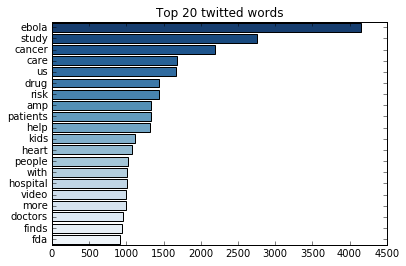

In [6]:
import numpy as np, matplotlib.pyplot as plt
import seaborn as sns

#function wordCounter starts from an rdd, processes it and returns a pandas dataframe
def wordCounter(daje):
    
    #start from rdd_final (or another rdd, like daje), and take only the pre-processed 
    #text of tweets. You obtain a list of lists: [['are', 'members'], [...]]. 
    #Each list corresponds to a tweet
    rddwc1= daje.map(lambda x: (x[1]))
    #create a single list with all the word using flatmap. 
    #From [['are'], ['members']] to ['are', 'members']
    rddwc2= rddwc1.flatMap(lambda xs: [x for x in xs])
    #count words. You obtain a list of tuples: [('are', 1), ('member', 1), ...]
    rddwc3= rddwc2.map(lambda x: (x,1))
    #count the occurrences of a certain word using reducebykey. 
    #You obtain a list of tuples, e.g. [('detox', 11), ('verge', 2), ... ]
    rddwc4= rddwc3.reduceByKey(lambda x, y: x+y)
    # keep only words beyond x occurrences (5 in this example)
    rddwc5= rddwc4.filter(lambda x: x[1] >= 5)
    #sort word frequency by descending order
    rddwc6 = rddwc5.sortBy(lambda x: -x[1])
    
    # Now we go from rdd to dataframe. Create schema for the dataframe
    df = rddwc6.map(lambda x: Row(word=x[0], count=x[1]))
    # Create dataframe using the schema.
    df = sqlContext.createDataFrame(rddwc6, ['word','count'])
    # Sort descending order
    df = df.sort(desc("count"))
    #from sql to pandas dataframe
    df= df.toPandas()
    
    return df

dfWC= wordCounter(rdd_final)
# plot top 20 words
dfWC1= dfWC[:20]

#use seaborn package barplot, with saturated colours for more frequent words
pal = sns.color_palette("Blues", len(dfWC1))
rank = dfWC1['count'].argsort().argsort()  
sns.barplot(y=dfWC1['word'], x=dfWC1['count'], palette=np.array(pal[::1])[rank])
plt.xlabel('')
plt.ylabel('')
plt.title('Top 20 twitted words')
plt.show()

**Wordclouds**

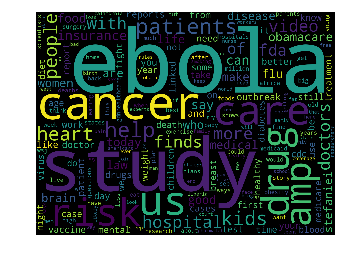

In [6]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import matplotlib.pyplot as plt

#check if packages are available
# check available python packages
# !pip list --isolated
#choose number of words to plot in the wordcloud before drawing it
dfWC2= dfWC[:200]

#GENERATE the WORDCLOUD FROM DICTIONARY (converting the pandas dataframe to dictionary)
#from pandas dataframe to dictionary [{'mad': 11, 'mobile': 29, ...}]
frequencies = dfWC.set_index('word').T.to_dict('records')

#Define stopwords. To add more stopwords: stopwords.add("with", "ema")
stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='black', stopwords=stopwords, width=2000, 
            height=1500, random_state=50).generate_from_frequencies(dict(*frequencies))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**We can also produce a more visually appealing word cloud using the twitter logo as mask...**

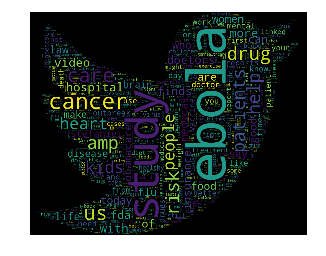

In [7]:
import imageio
# We can also apply a Twitter mask to the wordcloud: it is more difficult to read, 
#but more visually appealing. 
im = imageio.imread('https://raw.githubusercontent.com/rasbt/datacollect/master/dataviz/twitter_cloud/twitter_mask.png')
bird = WordCloud(background_color='black', stopwords=stopwords, max_words= 1000, 
    width=1800, height=1400, random_state=50, mask= im).generate_from_frequencies(dict(*frequencies))
print(bird)
fig = plt.figure(1)
plt.imshow(bird)
plt.axis('off')
plt.show()

### 3. LDA
LDA input is a set of word count vectors created via the CountVectorizer feature. The function MakeLda was created to perform all the necessary transformation from the input dataframe to the final LDA fit. 3 topics were setted for the LDA analysis, and a dataframe was created to store the most relevant words for each topic. All three topics were dominated by the same first words, like ‘Ebola’, and ‘cancer’. No great difference was detected changing the number of k topics, nor increasing the number of words taken into consideration (here we show the first 25, but we tested up to 100 words). Indeed, in the original LDA matrix the weights of the words, expressing the probability that a term belongs to a certain latent topic, were very low (~0.001) and similar among different topics, thus reflecting the difficulty of the algorithm to create well-defined and highly homogeneous topic classes.

In [10]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import HashingTF, IDF, StringIndexer

#prepare data for LDA
full_rdd= LockAndLoad(filename_array)
#start from rdd structure
lda_rdd= initialize(rdd_final)
#trannsform to dataframe
lda_df= to_indexed_dataframe(rdd_final)

In [11]:
#define function to calculate LDA
def makeLda(pippo):
    
    # create vector object
    cv = CountVectorizer(inputCol="text", outputCol="vectors")
    #map action. model fitted on the single workers
    lda_an=cv.fit(pippo)
    vocab= lda_an.vocabulary
    #reduce action, all the map actions are reduced/put togheter, and then showed
    #lda_an.transform(df).show()
    lda_trans= lda_an.transform(pippo)
    #specify parameters of LDA; k=3 number of topics. 
    lda = LDA(k=3, seed=1, optimizer="em", featuresCol='vectors')

    #run LDA on 
    model = lda.fit(lda_trans)
    return model, vocab 

#call function pippo on df to create vocabulary and fit lda
modelLda, vocab = makeLda(lda_df)
modelLda.describeTopics().show()
#to see vocabulary
#vocab 

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[0, 1, 2, 4, 3, 5...|[0.01007792539721...|
|    1|[0, 1, 2, 3, 4, 5...|[0.01027602072990...|
|    2|[0, 1, 2, 3, 4, 6...|[0.00987090949913...|
+-----+--------------------+--------------------+



In [14]:
import pandas as pd

#define number of words (a variable) to consider in order to distinguish between different topics.
a= 25
topics= modelLda.describeTopics(maxTermsPerTopic = a)
topics_rdd = topics.rdd

#create a list that map all the termIndices (now they are numbers) 
#to the corresponding words in the vocabulary list
topics_words = topics_rdd\
       .map(lambda row: row['termIndices'])\
       .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
       .collect()

#create a list with all the words of the three topics (0,1,2)
Ldalist= []
for idx, topic in enumerate(topics_words):
    for word in topic:
        Ldalist.append(word)
# uncomment print if you want to visualize the list
# print(Ldalist)

# this function takes a list of lists storing the output of the LDA and returns 
#a pandas dataframe ordering them 
def makeAtable(paperino):
    
    #separate the three topics in a new list: [[topic 0 words], [topic1], [topic3]], 
    #where a is the number of words per topic
    topic_lists = [paperino[x:x+a] for x in range(0, len(paperino), a)]

    #from the list of lists create a rdd, and then from the rdd create a dataframe 
    df_lda = sc.parallelize(topic_lists).toDF()
    
    #now transpose the dataframe, so that columns are the three topics, and rows 
    #are the most important words. Use pandas dataframes
    topic_table= df_lda.toPandas().transpose()
    #give a name to the columns. This part of the function should be modified 
    #if the number of topic is changed
    topic_table.columns = ['Topic 1', 'Topic 2', 'Topic 3']
    
    return topic_table

makeAtable(Ldalist)

,Topic 1,Topic 2,Topic 3
_1,ebola,ebola,ebola
_2,study,study,study
_3,cancer,cancer,cancer
_4,us,care,care
_5,care,us,us
_6,drug,drug,risk
_7,risk,risk,drug
_8,amp,patients,help
_9,patients,help,amp
_10,help,amp,patients


### 4. Multinomial regression

Data was split on a 80-20 ratio between train and test subsets. A grid search method was implemented to explo-re 3x3x3 = 27 combinations of the hyperparameters, namely the elastic net regularizer (elasticNetParam), regres-sion parameter (regParam) and the hashing vector (hashingTF.numFeatures). The final model was selected on the basis of the best test accuracy among all the possible tested combinations, thus providing an highly reliable result. The trainbest function was defined to implement the regression analysis and its grid search. The best accuracy was 0.87, that is the right news agency cathegory was correctly identified from tweet messages 87 times out of 100, which we consider a thrilling result, considering the similarity of the messages and topics.

In [5]:
                
                    #### LOADING PACKAGES ####
    
from pyspark.ml.feature import HashingTF, IDF, StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
    

# we want a function that tests all the different models and return the best one:
def trainbest(df, weights_array):
    # Initialize Multinomial Logistic Regression:
    lr = LogisticRegression(maxIter=5, family="multinomial")
    # define the hashing function:
    hashingTF = HashingTF(inputCol="text", outputCol="features")

    # define the schedule for the ParamGrid search, paramgrid will iterate 
    #through different parameters combinations starting from the hashing 
    #function(hashingTF), modifying vector size(numFeatures) and then running 
    #the logistic regression(lr) with different parameters configuration(regParam & elastNetParam).
    schedule = Pipeline(stages=[hashingTF, lr])

    # build up the grid for grid search
    paramGrid = ParamGridBuilder()\
        .addGrid(hashingTF.numFeatures, [5, 8, 6]) \
        .addGrid(lr.regParam, [0.1, 0.03, 0.01]) \
        .addGrid(lr.elasticNetParam, [0.0, 0.3, 1.0])\
        .build()

    # define the evaluator for multiclass classification, this is needed to calculate 
    #the accuracy for each iteration and choose the best model, 
    # this is also needed to calculate the accuracy with the test sample.
    MCevaluator = MulticlassClassificationEvaluator(metricName="accuracy")

    # this initialize the grid search, define the schedule, the grid and the evaluator, 
    # with the size for train and validation set fixed to 0.8 of the original train set.    
    tvs = TrainValidationSplit(estimator=schedule,
                               estimatorParamMaps=paramGrid,
                               evaluator=MCevaluator,
                               # 80% of the data will be used for training, 20% for validation.
                               trainRatio=0.8)
    # initialize an empty array to store test accuracy
    test_acc = []
    # initialize an empty array to store models. 
    models = []
    # iterate throught the weight array to split dataset in different size.
    for tr_weight in weights_array:
        # get test size
        te_weight = 1-tr_weight
        # split data with the actual loop stage value
        train, test = df.randomSplit([tr_weight, te_weight])
        # fit model, the model that perform best in the gridsearch 
        #with the validation set is memorized
        model = tvs.fit(train)
        # make predictions on test data
        predictions = model.transform(test)
        # calculate accuracy
        accuracy = MCevaluator.evaluate(predictions)
        accuracy = 1.0 - accuracy 
        # store accuray and the model in the arrays for comparison
        test_acc.append(accuracy)
        models.append(model)
        print("... best model for this iteration: Test Error = %g " % (accuracy))
        # repeat...for all the train,test size array...
    # once the loop is over...    
    # check which one has the best accuracy and report the number
    best_acc = max(test_acc)
    #  the best trained model is the one which have obtained the best accuracy 
    #for that particular train-test split.
    best_model = models[test_acc.index(max(test_acc))]
    
    return best_acc, best_model

In [6]:
# Initialize RDD #
rdd = initialize(full_rdd)
# Transform to dataframe #
# print(rdd.take(1)) <<<< FOR DEBUG
df = to_indexed_dataframe(rdd)
# define a set of weights to split the dataset #
split_weights = [0.8]
# call the function to train and obtain the best trained model and 
#its accuracy on test data. #
acc, model = trainbest(df, split_weights)

print(" Overall best model has Test Error = %g " % acc)

... best model for this iteration: Test Error = 0.867887 
 Overall best model has Test Error = 0.867887 


## Conclusions

The first research aim of our work was to understand what health topics used to trend on Twitter between 2013 and 2015. The Ebola pandemy dominated the health landscape at least from July 2014 to January 2015. The interest about this disease was likely centered around the possibility of it spreading over the USA, as other trending words were ‘Dallas’ (first confirmed american case) and ‘CDC’ (Centers for Disease Control and Prevention, the health agency that tackled Ebola in the USA). Interestingly, the Ebola virus killed only 2 people out of 11 known cases in the USA. Therefore, our first conclusion is that Twitter seems more geared towards health ‘emergencies’ more than lifestyle and more ‘traditional’ and yet deadly clinical conditions, though cancer is indeed the third most twitted word. This imbalance may have contributed in preventing the LDA analysis to identify meaningful clusters of topics,: Ebola-related words dwarfed all other topics in the period considered. The second research aim was to build an accurate multinomial regression mo-del to predict from the tweets the news agencies that originated them. Even if the tweets seemed at first analysis quite homogeneous, at least in terms of content, our model was able to achieve a 87% accuracy on the test set. This result was possible thanks to a clever hyperparameter fine-tuning, implemented with a 3x3x3 grid search iteration.

## Bibliography

1. Byrd, K., Mansurov, A., & Baysal, O. (2016, May). Mining Twitter data for influenza detection and surveillance. In Proceedings of the International Workshop on Software Engineering in Healthcare Systems (pp. 43-49). ACM.
2 Karami, A., Gangopadhyay, A., Zhou, B., & Kharrazi, H. (2017). Fuzzy approach topic discovery in health and medical corpora. International Journal of Fuzzy Systems, 1-12.
3. Gough, A., Hunter, R. F., Ajao, O., Jurek, A., McKeown, G., Hong, J., ... & Kee, F. (2017). Tweet for behavior change: using social media for the dissemination of public health messages. JMIR public health and surveillance, 3 (1).
4. Kapp, J. M., Hensel, B., & Schnoring, K. T. (2015). Is Twitter a forum for disseminating research to health policy makers? Annals of epidemiology, 25(12), 883-887.
5 Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3 (Jan), 993-1022.
6. McNeill, A., Harris, P. R., & Briggs, P. (2016). Twitter influence on UK vaccination and antiviral uptake during the 2009 H1N1 pandemic. Frontiers in public health, 4, 26.